<a href="https://colab.research.google.com/github/NRafif/Machine-Learning/blob/main/Model_With_MobileNetV27.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LIBRARY

In [32]:
from google.colab import files    # Untuk upload files
import zipfile                    # Untuk unzip file
import os                         # Untuk interaksi dengan os
import matplotlib.pyplot as plt   # Untuk visualisasi data
import matplotlib.image as mpimg  # Membaca dan memanipulasi gambar
from google.colab import drive    # Untuk mengakses google drive
import tensorflow as tf           # Library utama untuk Machine learning
import numpy as np                # Library untuk komputasi numerik
from PIL import Image
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [33]:
batch_size = 64
img_height = 224
img_width = 224

# PERSIAPAN DATASET


Mengambil dataset dari kaggle

In [34]:
!pip install -q Kaggle

In [35]:
# uploaded = files.upload()

In [36]:
!mkdir -p ~/.kaggle                #membuat folder .kaggle di root
!mv kaggle.json ~/.kaggle/         #memindahkan file kaggle.json ke folder ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json   #merubah permission file kaggle.json

mv: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [37]:
!kaggle datasets download -d nofalrafif/cat-skin-disease

Dataset URL: https://www.kaggle.com/datasets/nofalrafif/cat-skin-disease
License(s): unknown
cat-skin-disease.zip: Skipping, found more recently modified local copy (use --force to force download)


Load Dataset


In [38]:
# Extract zipfile
! unzip "/content/cat-skin-disease.zip" -d.

Archive:  /content/cat-skin-disease.zip
replace ./dataset/CAT SKIN DISEASE/Health/-XB1nkYr8x8_jpg.rf.488035c88ae23b7e516202935dcd5cb4.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: ./dataset/CAT SKIN DISEASE/Health/-XB1nkYr8x8_jpg.rf.488035c88ae23b7e516202935dcd5cb4.jpg  
  inflating: ./dataset/CAT SKIN DISEASE/Health/-e0QDP4sFro_jpg.rf.79e7e30bdb48ec52d1174ef79c91b9ff.jpg  
  inflating: ./dataset/CAT SKIN DISEASE/Health/-q6SDw4zo90_jpg.rf.a50638511d43faa8b2d1b745421a5b1e.jpg  
  inflating: ./dataset/CAT SKIN DISEASE/Health/0001-YE-pDvdMSPU_jpg.rf.8e5c96d008a7de691af15f13c9c91741.jpg  
  inflating: ./dataset/CAT SKIN DISEASE/Health/0002-Kpmi7OMZGco_jpg.rf.25bb175383508dbc050f3a7a008cb384.jpg  
  inflating: ./dataset/CAT SKIN DISEASE/Health/0002-Kpmi7OMZGco_jpg.rf.792af3151465d9328ca952010a6cb8d4.jpg  
  inflating: ./dataset/CAT SKIN DISEASE/Health/0002-Kpmi7OMZGco_jpg.rf.ce000713629e2557290f208d0f713cbf.jpg  
  inflating: ./dataset/CAT SKIN DISEASE/Health/0003-Zx043ICtTtE_jp

Menentukan class

In [39]:
cat_disease = "/content/dataset/CAT SKIN DISEASE"
cat_disease_classes = os.listdir(cat_disease)

In [40]:
print("Cat Skin Disease Class :")
for class_name in cat_disease_classes:
  if os.path.isdir(os.path.join(cat_disease, class_name)):
    print(class_name)

Cat Skin Disease Class :
Scabies
Health
Ringworm


Preview Gambar


Scabies
Total Image :  509
Resolusi Gambar :  (200, 286, 4)


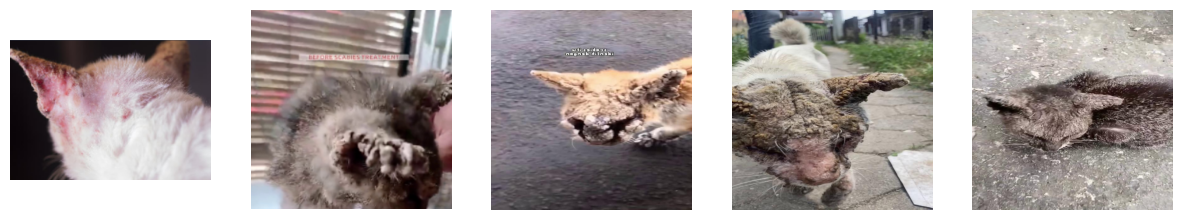


Health
Total Image :  485
Resolusi Gambar :  (640, 640, 3)


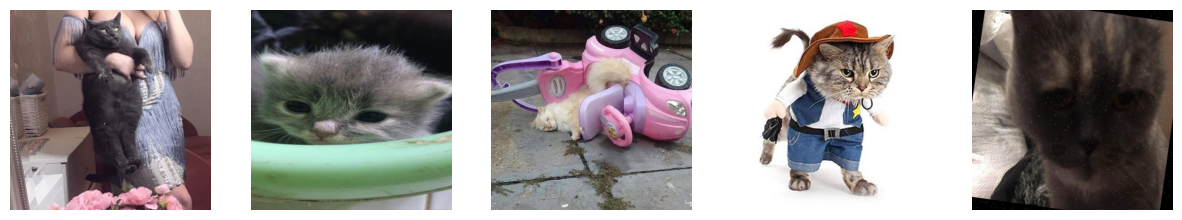


Ringworm
Total Image :  572
Resolusi Gambar :  (640, 640, 3)


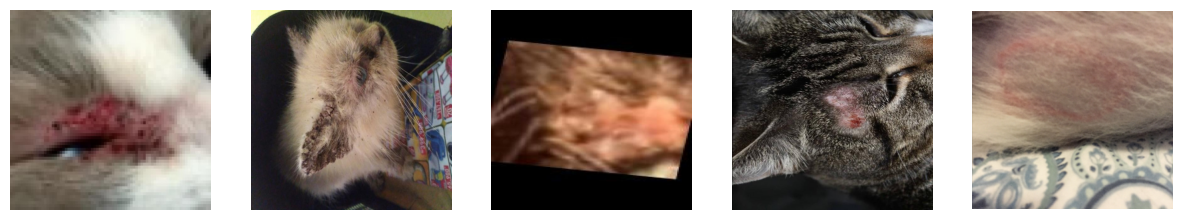

In [41]:
for item in cat_disease_classes:
    print("")
    print(item)
    class_dir = os.path.join(cat_disease, item)
    class_images = [img for img in os.listdir(class_dir) if img.endswith(('.png', '.jpg', '.jpeg'))]

    # Menghitung total image di setiap kelas
    num_images = len(class_images)
    print("Total Image : ", num_images)

    # Menghitung resolusi pada gambar pertama
    img_path = os.path.join(class_dir, class_images[0])
    img = mpimg.imread(img_path)
    image_shape = img.shape
    print("Resolusi Gambar : ", image_shape)

    # Menampilkan beberapa gambar
    plt.figure(figsize=(15, 5))
    for i in range(min(5, len(class_images))):  # Tampilkan maksimum 5 gambar atau sesuai jumlah yang tersedia
        sp = plt.subplot(1, 5, i + 1)
        img = mpimg.imread(os.path.join(class_dir, class_images[i]))
        plt.axis('off')
        plt.imshow(img)
    plt.show()


# PREPOCESING DATA


Split data

In [42]:
def train_val_Dataset():
  training_dataset, validation_dataset = tf.keras.utils.image_dataset_from_directory(
      cat_disease,
      image_size=(img_height, img_width),
      color_mode='rgb',
      batch_size= batch_size,
      label_mode='categorical',
      validation_split=0.2,
      subset='both',
      shuffle=True,
      seed=42
  )

  return training_dataset, validation_dataset

In [43]:
# Membuat dataset
training_dataset, validation_dataset = train_val_Dataset()

Found 1566 files belonging to 3 classes.
Using 1253 files for training.
Using 313 files for validation.


In [44]:
# Melihat batch pertama dari image dan labels
for image_batch, labels_batch in training_dataset.take(1):
  example_batch = image_batch
  labels_batch = labels_batch

  print(f"maximum pixel value of images : {np.max(example_batch)}.\n")
  print(f"Image batch shape: {image_batch.shape}")
  print(f"Labels batch shape: {labels_batch.shape}")

maximum pixel value of images : 255.0.

Image batch shape: (64, 224, 224, 3)
Labels batch shape: (64, 3)


Augmentation

In [45]:
def create_augmentation_model():
    """
    Creates and returns the augmentation model.
    """
    augmentation_model = tf.keras.Sequential([
        tf.keras.layers.RandomFlip("horizontal_and_vertical"),
        tf.keras.layers.RandomRotation(0.3),
        tf.keras.layers.RandomZoom(0.3),
        tf.keras.layers.RandomBrightness(0.3),
        tf.keras.layers.RandomContrast(0.3),
        tf.keras.layers.GaussianNoise(0.1)
    ])
    return augmentation_model

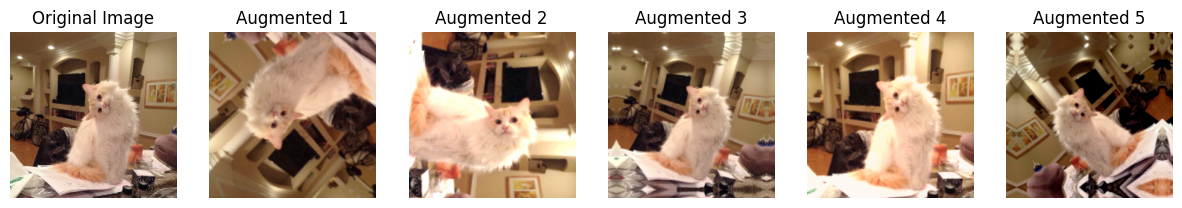

In [46]:
# Store the augmentation model as data_augmentor
data_augmentor = create_augmentation_model() # Now, this stores the model directly

for image_batch, labels_batch in training_dataset.take(1):
  sample_image = image_batch[0]  # Take the first image from the batch
  break

images = [tf.keras.utils.array_to_img(sample_image)]

for _ in range(5):
    # Call the augmentation_model
    image_aug = data_augmentor(tf.expand_dims(sample_image, axis=0), training=True)  # Use data_augmentor
    image_aug = tf.keras.utils.array_to_img(tf.squeeze(image_aug))  # Assuming output is a list or tuple
    images.append(image_aug)


fig, axs = plt.subplots(1, 6, figsize=(15, 5))
for ax, image, title in zip(axs, images, ['Original Image', 'Augmented 1', 'Augmented 2', 'Augmented 3','Augmented 4','Augmented 5']):
    ax.imshow(image, cmap='gray')
    ax.set_title(title)
    ax.axis('off')

plt.show()

# MODELING

In [47]:
def create_transfer_learning_model():
    # Load MobileNetV2 without the top layer
    base_model = MobileNetV2(
        weights='imagenet',
        include_top=False,
        input_shape=(224, 224, 3)
    )

    # Freeze the base model
    for layer in base_model.layers[-50:]:
        layer.trainable = False

    # Augmentation layers
    augmentation_layers = create_augmentation_model()

    # Add custom layers
    # The Input layer is added to specify the input shape explicitly
    x = base_model.output
    x = GlobalAveragePooling2D()(x)

    # x = Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
    # x = tf.keras.layers.BatchNormalization()(x)
    # x = tf.keras.layers.Dropout(0.5)(x)

    # x = Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)  # Tambahkan lapisan fully connected
    # x = tf.keras.layers.BatchNormalization()(x)
    # x = tf.keras.layers.Dropout(0.4)(x)

    x = Dense(128, activation='relu')(x)  # Tambahkan lapisan fully connected
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.4)(x)

    predictions = Dense(3, activation='softmax')(x)  # Sesuaikan dengan jumlah kelas Anda

    # Define the final model
    model = Model(inputs=base_model.input, outputs=predictions)

    # Compile the model
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
    model.compile(
        optimizer='adam',
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )

    return model

In [48]:
create_transfer_learning_model().summary()

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_11            │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 112, 112, 32)   │            864 │ input_layer_11[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 112, 112, 32)   │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 112, 112, 32)   │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 112, 112, 32)   │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 112, 112, 16)   │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 112, 112, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 112, 112, 96)   │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 112, 112, 96)   │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 112, 112, 96)   │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 113, 113, 96)   │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 56, 56, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├──────────────────────

 Total params: 2,422,851 (9.24 MB)

 Trainable params: 533,379 (2.03 MB)

 Non-trainable params: 1,889,472 (7.21 MB)

Buat fungsi callback

In [49]:
# class early_stopping_callback(tf.keras.callbacks.Callback):
#   def on_epoch_end(self, epoch, logs=None):
#     if logs.get('accuracy')>=0.9 and logs.get('val_accuracy')>=0.85:
#       print("\nReached 70% train accuracy and 70% val accuracy so cancelling training!")
#       self.model.stop_training = True

In [58]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, mode='min')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=8, min_lr=1e-3, mode='min', verbose=1)

Mulai train model

In [51]:
history = create_transfer_learning_model().fit(
    training_dataset.map(lambda x, y: (data_augmentor(x, training=True), y)),
    validation_data=validation_dataset,
    epochs=100,
    verbose=2,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/100
20/20 - 77s - 4s/step - accuracy: 0.6712 - loss: 0.8423 - val_accuracy: 0.4696 - val_loss: 1.3448 - learning_rate: 0.0010
Epoch 2/100
20/20 - 25s - 1s/step - accuracy: 0.8468 - loss: 0.4827 - val_accuracy: 0.3546 - val_loss: 3.4906 - learning_rate: 0.0010
Epoch 3/100
20/20 - 25s - 1s/step - accuracy: 0.8563 - loss: 0.4421 - val_accuracy: 0.3642 - val_loss: 3.4040 - learning_rate: 0.0010
Epoch 4/100
20/20 - 26s - 1s/step - accuracy: 0.8619 - loss: 0.3868 - val_accuracy: 0.4601 - val_loss: 2.2351 - learning_rate: 0.0010
Epoch 5/100
20/20 - 40s - 2s/step - accuracy: 0.8875 - loss: 0.3285 - val_accuracy: 0.4537 - val_loss: 2.2027 - learning_rate: 0.0010
Epoch 6/100
20/20 - 25s - 1s/step - accuracy: 0.9050 - loss: 0.2686 - val_accuracy: 0.5335 - val_loss: 1.4603 - learning_rate: 0.0010
Epoch 7/100
20/20 - 41s - 2s/step - accuracy: 0.9002 - loss: 0.2716 - val_accuracy: 0.5208 - val_loss: 1.8982 - learning_rate: 0.0010
Epoch 8/100
20/20 - 41s - 2s/step - accuracy: 0.9106 - loss: 0

# Hasil Model

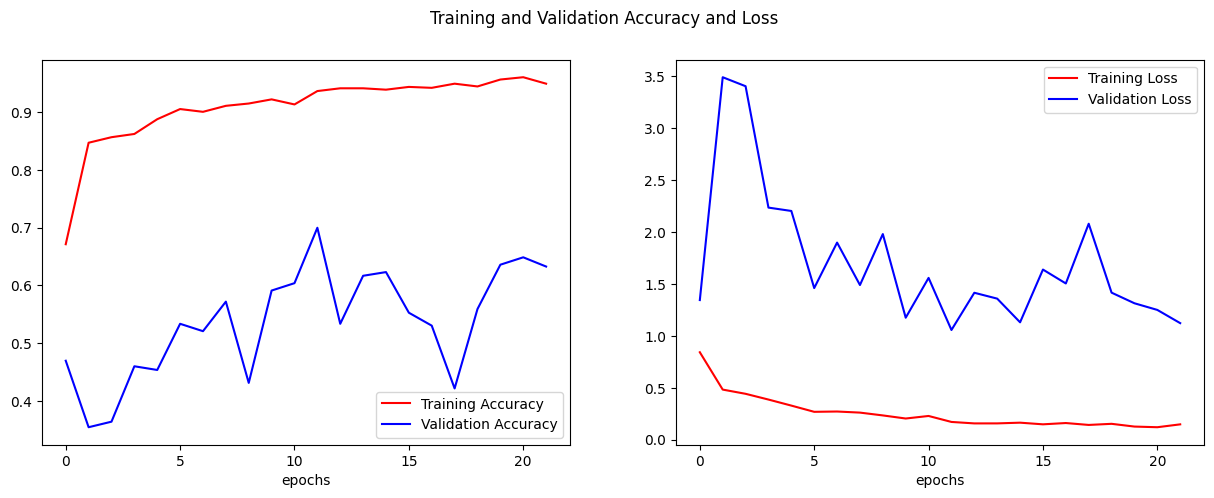

In [55]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

fig, axs = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Training and Validation Accuracy and Loss')

# Define data and labels for each subplot
data_labels = [
    (acc, val_acc, 'Accuracy'),
    (loss, val_loss, 'Loss')
]

# Iterate through subplots and data
for i, (data, label) in enumerate(zip([(acc, val_acc), (loss, val_loss)], ["Accuracy", "Loss"])):
    axs[i].plot(epochs_range, data[0], 'r', label="Training " + label)
    axs[i].plot(epochs_range, data[1], 'b', label="Validation " + label)
    axs[i].legend()
    axs[i].set_xlabel('epochs')

plt.show()

Model 2

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Predicted class: Ringworm
Prediction probabilities: [[0.1835025  0.39547178 0.42102575]]


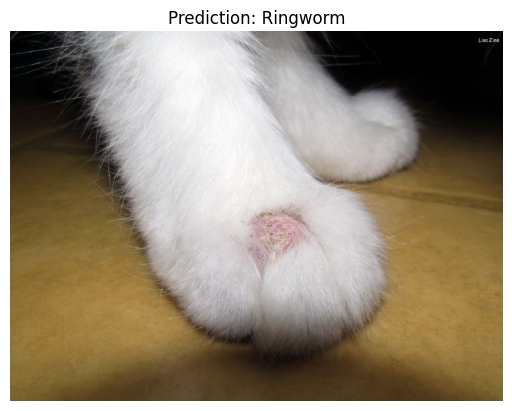

In [53]:
def predict_image(image_path, model):
    img = Image.open(image_path)
    img = img.resize((img_height, img_width))  # Resize image

    # Convert image to RGB format
    img = img.convert('RGB')  # This line is added to convert the image to RGB

    img_array = np.array(img) / 255.0  # Normalize pixel values
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

    prediction = model.predict(img_array)
    predicted_class = np.argmax(prediction)

    # Memprediksi kelas yang
    predicted_class_name = cat_disease_classes[predicted_class]

    return predicted_class_name, prediction


# Upload file
uploaded = files.upload()

# Informasi file yang diupload
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

# Membuat prediksi
image_path = fn # Menggunakan nama file yang diupload
predicted_class_name, prediction = predict_image(image_path, create_transfer_learning_model()) # Gunakan model yang telah dilatih

print(f"Predicted class: {predicted_class_name}")
print(f"Prediction probabilities: {prediction}")

# Display the uploaded image
img = Image.open(image_path)
plt.imshow(img)
plt.axis('off')
plt.title(f"Prediction: {predicted_class_name}")
plt.show()

Saving 6233fb293f22d.jpg to 6233fb293f22d (1).jpg
User uploaded file "6233fb293f22d (1).jpg" with length 163496 bytes
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Predicted class: Scabies
Prediction probabilities: [[0.8682613  0.06408901 0.06764971]]


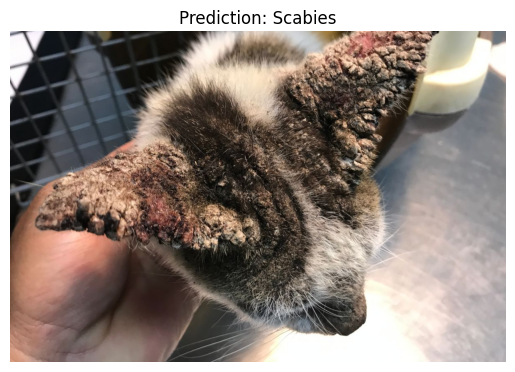

In [57]:
def predict_image(image_path, model):
    img = Image.open(image_path)
    img = img.resize((img_height, img_width))  # Resize image

    # Convert image to RGB format
    img = img.convert('RGB')  # This line is added to convert the image to RGB

    img_array = np.array(img) / 255.0  # Normalize pixel values
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

    prediction = model.predict(img_array)
    predicted_class = np.argmax(prediction)

    # Memprediksi kelas yang
    predicted_class_name = cat_disease_classes[predicted_class]

    return predicted_class_name, prediction


# Upload file
uploaded = files.upload()

# Informasi file yang diupload
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

# Membuat prediksi
image_path = fn # Menggunakan nama file yang diupload
predicted_class_name, prediction = predict_image(image_path, create_transfer_learning_model()) # Gunakan model yang telah dilatih

print(f"Predicted class: {predicted_class_name}")
print(f"Prediction probabilities: {prediction}")

# Display the uploaded image
img = Image.open(image_path)
plt.imshow(img)
plt.axis('off')
plt.title(f"Prediction: {predicted_class_name}")
plt.show()